In [35]:
import torch
import numpy as np 
import pandas as pd 

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [36]:
data = pd.read_csv('train.csv')

labels = data['label'] 
features = data.drop('label', axis = 1)

In [37]:
features = torch.from_numpy(features.values.reshape(-1,1,28,28))
features = features.type(torch.float32)

labels = torch.from_numpy(labels.values)
labels = labels.type(torch.long)

In [38]:
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset

train_data = TensorDataset(features, labels)

idx = list(range(len(train_data)))
mid = int(0.9*len(train_data))

# split and suffle indexes
train_idx = SubsetRandomSampler(idx[:mid])
test_idx = SubsetRandomSampler(idx[mid:])

# data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, sampler=train_idx)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=20, sampler=test_idx)


### Visualize a Batch of Training Data

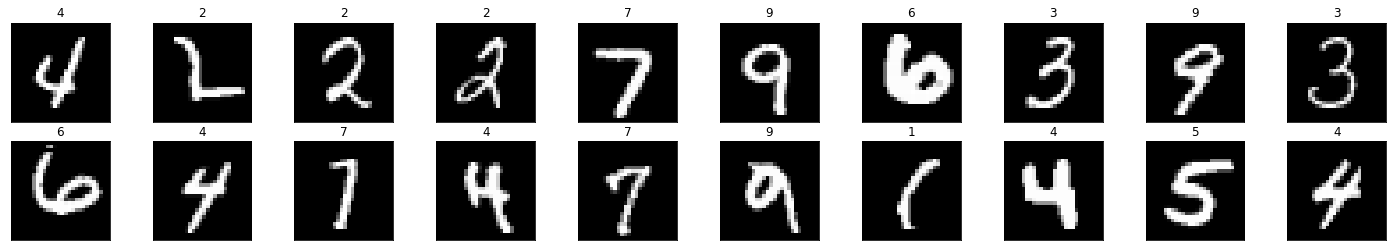

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

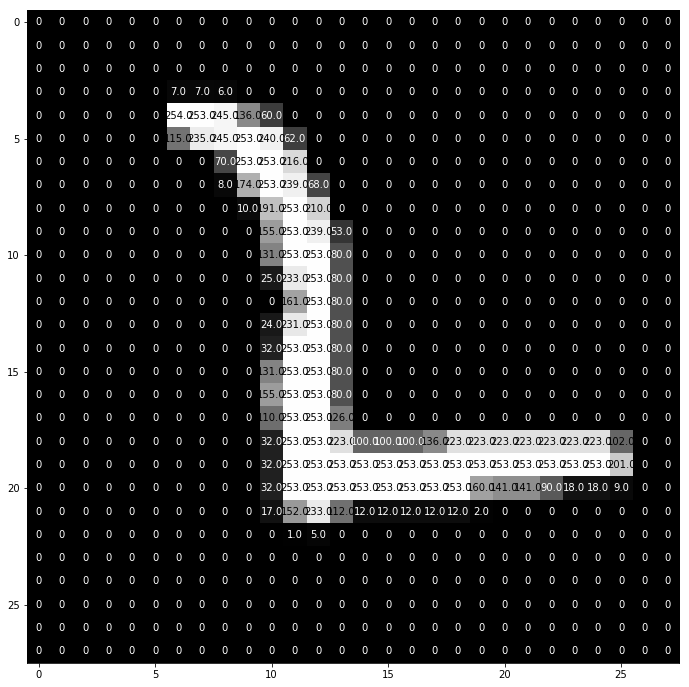

In [40]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [41]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(1, 5, 3, padding=1)        
        self.conv2 = nn.Conv2d(5, 10, 3, padding=1)        
        self.conv3 = nn.Conv2d(10, 20, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layers
        self.fc1 = nn.Linear(20 * 7 * 7, 100)        
        self.fc2 = nn.Linear(100, 10)
        # dropout layer 
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 20 * 7 * 7)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=980, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

In [42]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [46]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_MNIST_CNN.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.028733 	Validation Loss: 0.003615
Validation loss decreased (inf --> 0.003615).  Saving model ...
Epoch: 2 	Training Loss: 0.027501 	Validation Loss: 0.004128
Epoch: 3 	Training Loss: 0.024282 	Validation Loss: 0.003695
Epoch: 4 	Training Loss: 0.023954 	Validation Loss: 0.003785
Epoch: 5 	Training Loss: 0.021629 	Validation Loss: 0.007080
Epoch: 6 	Training Loss: 0.023147 	Validation Loss: 0.003071
Validation loss decreased (0.003615 --> 0.003071).  Saving model ...
Epoch: 7 	Training Loss: 0.021275 	Validation Loss: 0.003408
Epoch: 8 	Training Loss: 0.019983 	Validation Loss: 0.002926
Validation loss decreased (0.003071 --> 0.002926).  Saving model ...
Epoch: 9 	Training Loss: 0.018787 	Validation Loss: 0.003402
Epoch: 10 	Training Loss: 0.018738 	Validation Loss: 0.002996


###  Load the Model with the Lowest Validation Loss

In [47]:
model.load_state_dict(torch.load('model_MNIST_CNN.pt'))

---
## Test the Trained Network



In [48]:
correct = 0.0
test_loss = 0.0
total= 0.0

model.eval() # prep model for evaluation

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)  
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct += np.squeeze(pred.eq(target.data.view_as(pred))).sum()
    total += len(data)
    
# calculate and print average test loss
test_loss = test_loss/total
print('Test Loss: {:.6f}'.format(test_loss)) 

# calculate and print accuracy
print('Test Accuracy: {:.2f}% ({}/{})' .format(100. * np.float(correct) / total, 
                                           correct, total))
        


Test Loss: 0.029260
Test Accuracy: 99.19% (4166/4200.0)


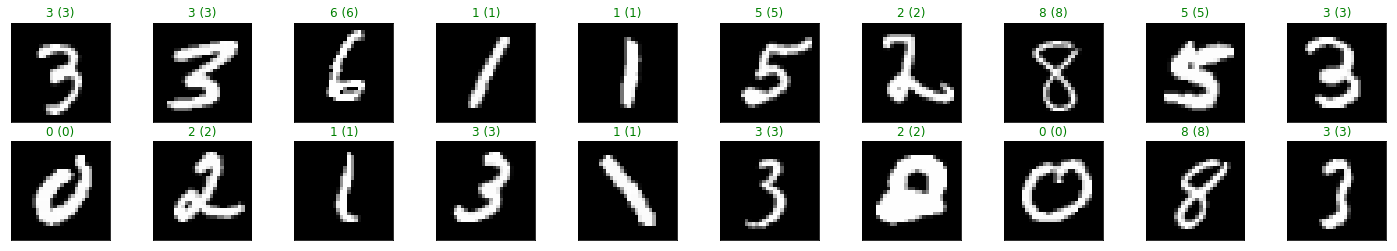

In [11]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [12]:
tester_data = pd.read_csv('test.csv')
tester_data = torch.from_numpy(tester_data.values.reshape(-1,1,28,28))
tester_data = tester_data.type(torch.float)
tester_loader = torch.utils.data.DataLoader(tester_data, batch_size=20)

In [13]:
model.eval() 
result = []

for data in tester_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    _, pred = torch.max(output, 1)
    pred = pred.numpy()
    result += pred.tolist()

results = pd.Series(result,name="Label")
Imageld = pd.Series(range(1,len(result)+1),name="Imageld")

submission = pd.concat([Imageld,results],axis = 1)
submission.to_csv("submission.csv",index=False)

In [14]:
x = pd.read_csv('submission.csv')
print(x[:10])

   Imageld  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3
5        6      7
6        7      0
7        8      3
8        9      0
9       10      3
